Primeiras linhas dos dados:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450 

  0%|          | 23/1000000 [00:00<2:08:49, 129.38it/s]



Estrutura Complexa com Hill Climb e K2Score:
[('Pclass', 'Fare'), ('Pclass', 'Age'), ('Pclass', 'SibSp'), ('Fare', 'Age'), ('Fare', 'SibSp'), ('Age', 'SibSp'), ('Sex', 'Fare'), ('Sex', 'Survived'), ('Sex', 'Age'), ('Sex', 'SibSp'), ('Sex', 'Pclass'), ('Survived', 'Fare'), ('Survived', 'Age'), ('Survived', 'SibSp'), ('Survived', 'Pclass'), ('Parch', 'Fare'), ('Parch', 'Age'), ('Parch', 'SibSp'), ('Parch', 'Sex')]
Pais de 'Survived' no modelo K2: ['Sex']

Acurácia do Modelo Hill Climb + K2Score: 0.7877094972067039

Relatório de Classificação do Modelo Hill Climb + K2Score:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       110
           1       0.75      0.68      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



Working for n conditional variables: 4:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]



Estrutura estimada usando PC Algorithm:
[('SibSp', 'Fare'), ('Pclass', 'Survived'), ('Pclass', 'Fare'), ('Sex', 'Survived'), ('Parch', 'Fare'), ('Parch', 'SibSp'), ('Age', 'Parch')]
Pais de 'Survived' no modelo PC: ['Pclass', 'Sex']

Acurácia do Modelo PC Algorithm: 0.7877094972067039

Relatório de Classificação do Modelo PC Algorithm:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       110
           1       0.75      0.68      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



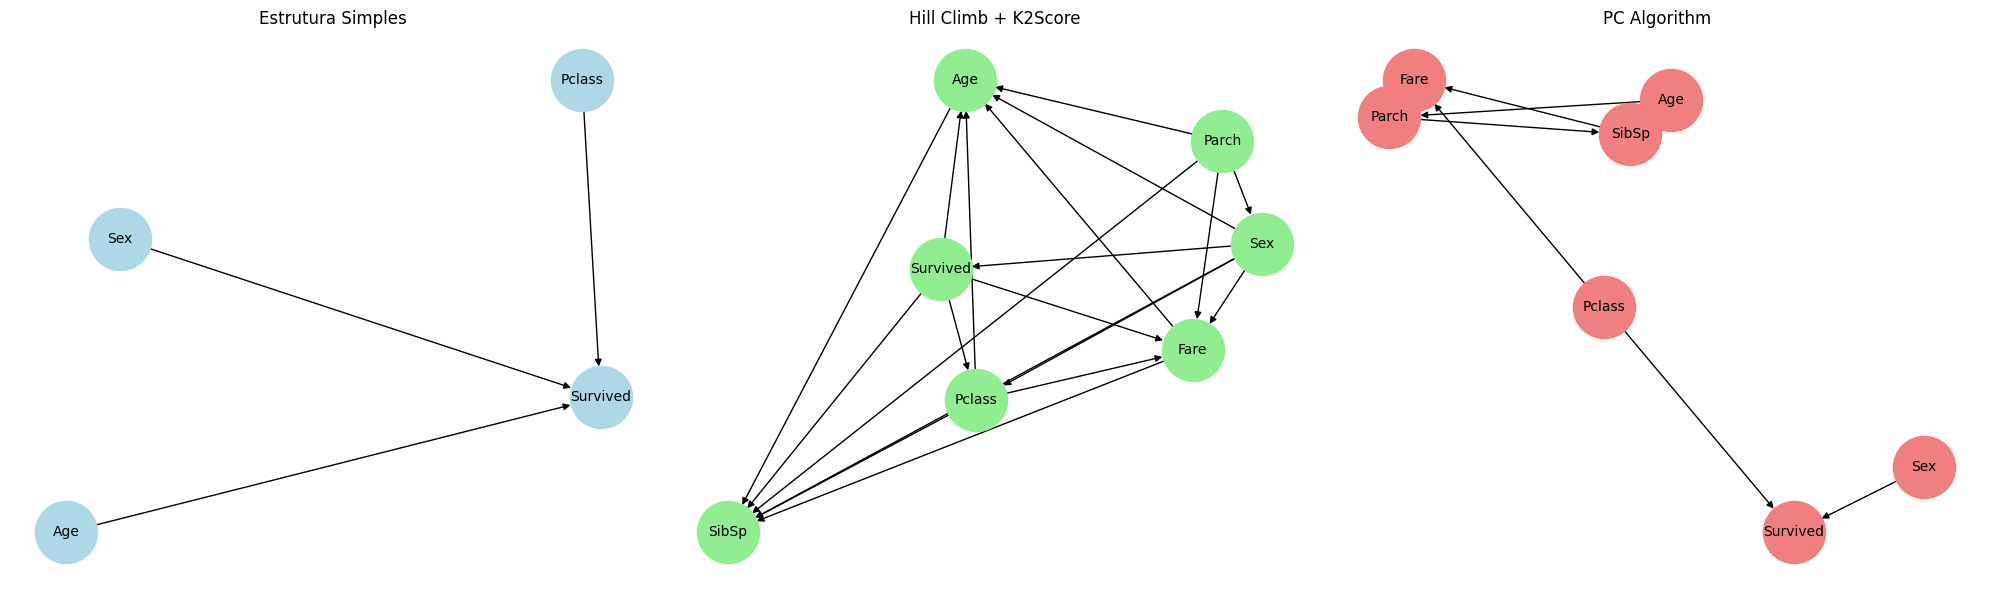

In [11]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import (BayesianEstimator, HillClimbSearch, K2Score, PC)
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Carregar e Pré-processar os Dados
data = pd.read_csv("C:\\programação\\projeto de IA\\titanic\\train.csv")  # Use 'train.csv' em vez de 'titanic.csv'

# Verificar as primeiras linhas do DataFrame
print("Primeiras linhas dos dados:")
print(data.head())

# Verificar os valores únicos nas colunas 'Survived' e 'Sex'
print("\nValores únicos em 'Survived':", data['Survived'].unique())
print("Valores únicos em 'Sex':", data['Sex'].unique())

data['Age'].fillna(data['Age'].median(), inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)
data['Cabin'].fillna('Unknown', inplace=True)
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(int)

print("\nApós o pré-processamento:")
print(data.head())
print("\nValores únicos em 'Survived':", data['Survived'].unique())
print("Valores únicos em 'Sex':", data['Sex'].unique())

# Remover colunas irrelevantes
data.drop(columns=['PassengerId', 'Ticket', 'Name', 'Embarked', 'Cabin'], inplace=True)

# Discretização
data['Age'] = pd.cut(
    data['Age'], bins=[0, 12, 18, 40, 60, 80],
    labels=[0, 1, 2, 3, 4], include_lowest=True
).astype(int)
data['Fare'] = pd.cut(
    data['Fare'], bins=[0, 7.91, 14.454, 31, data['Fare'].max()],
    labels=[0, 1, 2, 3], include_lowest=True
).astype(int)

# Converter tipos de dados para inteiro
columns_to_convert = ['Pclass', 'SibSp', 'Parch', 'Survived']
for col in columns_to_convert:
    data[col] = data[col].astype(int)

# Rearranjar as colunas para definir a ordem das variáveis
data = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]

# Verificar valores ausentes após discretização
print("\nValores ausentes por coluna após pré-processamento:")
print(data.isnull().sum())

# 2. Criar variável combinada para estratificação
data['Sex_Survived'] = data['Sex'].astype(str) + '_' + data['Survived'].astype(str)

# Verificar a distribuição conjunta no conjunto original
print("\nDistribuição de 'Sex' e 'Survived' no conjunto original:")
print(pd.crosstab(data['Sex'], data['Survived']))

# Dividir os dados em conjuntos de treinamento e teste usando a nova variável para estratificação
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['Sex_Survived']
)

# Remover a variável auxiliar dos conjuntos de dados
train_data = train_data.drop(columns=['Sex_Survived'])
test_data = test_data.drop(columns=['Sex_Survived'])

# Verificar a divisão
total_samples = len(data)
train_samples = len(train_data)
test_samples = len(test_data)

print(f'\nDivisão dos Dados:')
print(f'Treinamento: {train_samples} amostras ({(train_samples/total_samples)*100:.2f}%)')
print(f'Teste: {test_samples} amostras ({(test_samples/total_samples)*100:.2f}%)\n')

# Verificar a distribuição após a divisão
print("Distribuição de 'Sex' e 'Survived' no conjunto de Treinamento:")
print(pd.crosstab(train_data['Sex'], train_data['Survived']))

print("\nDistribuição de 'Sex' e 'Survived' no conjunto de Teste:")
print(pd.crosstab(test_data['Sex'], test_data['Survived']))

# Continue com o restante do código para treinar e avaliar os modelos
# Função para prever a sobrevivência
def predict_survival(model, test_data, evidence_vars, target_var='Survived'):
    inference = VariableElimination(model)
    predictions = []
    state_names = model.get_cpds(target_var).state_names[target_var]
    for idx, row in test_data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(
                variables=[target_var], evidence=evidence
            )
            prob = query_result.values
            predicted_state = query_result.state_names[target_var][np.argmax(prob)]
            predictions.append(int(predicted_state))
        except Exception as e:
            print(f'Erro na iteração {idx}: {e}')
            predictions.append(0)  # Valor padrão em caso de erro
    return predictions

# 3.1. Modelo Simples
model_simple = BayesianNetwork([
    ('Pclass', 'Survived'),
    ('Sex', 'Survived'),
    ('Age', 'Survived')
])
model_simple.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')
print("\nEstrutura Simples:")
print(model_simple.edges())

# Avaliar o modelo simples
evidence_vars_simple = ['Pclass', 'Sex', 'Age']
predictions_simple = predict_survival(
    model_simple, test_data, evidence_vars_simple
)
accuracy_simple = accuracy_score(test_data['Survived'], predictions_simple)
print("\nAcurácia do Modelo Simples:", accuracy_simple)
print("\nRelatório de Classificação do Modelo Simples:")
print(classification_report(test_data['Survived'], predictions_simple))

# 3.2. Modelo com Hill Climb e K2Score
hc_k2 = HillClimbSearch(train_data)
k2score = K2Score(train_data)
model_structure_k2 = hc_k2.estimate(
    scoring_method=k2score, max_indegree=None
)
model_k2 = BayesianNetwork(model_structure_k2.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')
print("\nEstrutura Complexa com Hill Climb e K2Score:")
print(model_k2.edges())

# Avaliar o modelo K2
parents_survived_k2 = list(model_k2.get_parents('Survived'))
print("Pais de 'Survived' no modelo K2:", parents_survived_k2)
predictions_k2 = predict_survival(
    model_k2, test_data, parents_survived_k2
)
accuracy_k2 = accuracy_score(test_data['Survived'], predictions_k2)
print("\nAcurácia do Modelo Hill Climb + K2Score:", accuracy_k2)
print("\nRelatório de Classificação do Modelo Hill Climb + K2Score:")
print(classification_report(test_data['Survived'], predictions_k2))

# 3.3. Modelo com PC Algorithm
pc = PC(train_data)
model_structure_pc = pc.estimate(return_type='dag')
model_pc = BayesianNetwork(model_structure_pc.edges())
model_pc.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')
print("\nEstrutura estimada usando PC Algorithm:")
print(model_pc.edges())

# Avaliar o modelo PC
parents_survived_pc = list(model_pc.get_parents('Survived'))
print("Pais de 'Survived' no modelo PC:", parents_survived_pc)
predictions_pc = predict_survival(
    model_pc, test_data, parents_survived_pc
)
accuracy_pc = accuracy_score(test_data['Survived'], predictions_pc)
print("\nAcurácia do Modelo PC Algorithm:", accuracy_pc)
print("\nRelatório de Classificação do Modelo PC Algorithm:")
print(classification_report(test_data['Survived'], predictions_pc))

# 4. Visualizar Estruturas das Redes Bayesianas
plt.figure(figsize=(20, 6))

# Estrutura Simples
plt.subplot(1, 3, 1)
G_simple = nx.DiGraph(model_simple.edges())
nx.draw(
    G_simple, with_labels=True, node_size=2000, node_color='lightblue', font_size=10
)
plt.title("Estrutura Simples")

# Estrutura Complexa com Hill Climb e K2Score
plt.subplot(1, 3, 2)
G_k2 = nx.DiGraph(model_k2.edges())
nx.draw(
    G_k2, with_labels=True, node_size=2000, node_color='lightgreen', font_size=10
)
plt.title("Hill Climb + K2Score")

# Estrutura estimada usando PC Algorithm
plt.subplot(1, 3, 3)
G_pc = nx.DiGraph(model_pc.edges())
nx.draw(
    G_pc, with_labels=True, node_size=2000, node_color='lightcoral', font_size=10
)
plt.title("PC Algorithm")

plt.tight_layout()
plt.show()


Acurácia do Modelo Simples: 0.7902
AUC do Modelo Simples: 0.8450

Relatório de Classificação do Modelo Simples:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        88
           1       0.77      0.65      0.71        55

    accuracy                           0.79       143
   macro avg       0.78      0.76      0.77       143
weighted avg       0.79      0.79      0.79       143



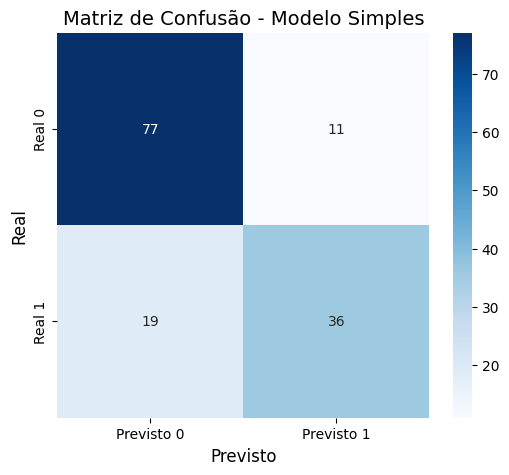

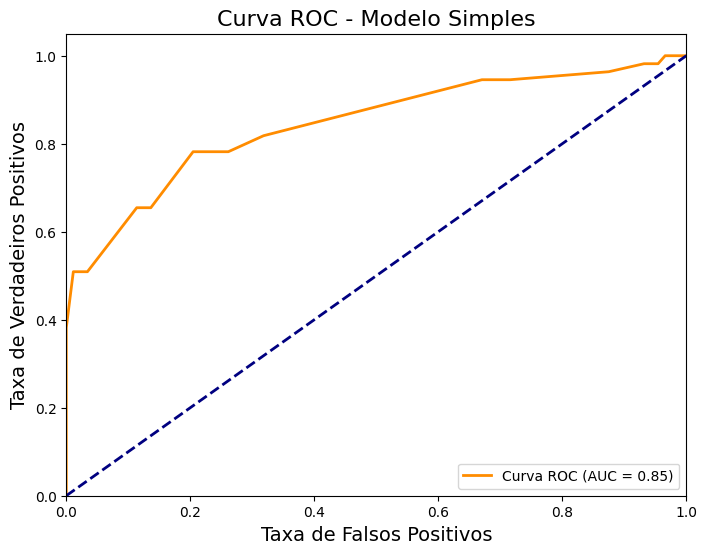

=== Discussão dos Resultados ===

A acurácia do modelo é de 0.79, o que indica que o modelo classificou corretamente 79.02% dos casos no conjunto de validação.
O valor de AUC é 0.85, o que sugere que o modelo tem uma boa capacidade de distinguir entre as classes 'Sobreviveu' e 'Não Sobreviveu'.

Analisando a matriz de confusão e o relatório de classificação, podemos observar:

- **Precisão**: Indica a proporção de predições positivas corretas em relação ao total de predições positivas.
- **Recall** (Sensibilidade): Mede a proporção de verdadeiros positivos identificados corretamente pelo modelo.
- **F1-Score**: Média harmônica entre precisão e recall, proporcionando uma medida balanceada.

A curva ROC mostra o trade-off entre a taxa de verdadeiros positivos e a taxa de falsos positivos. Um AUC próximo de 1 indica excelente desempenho. Neste caso, o modelo apresenta um desempenho satisfatório, mas há espaço para melhorias.

Possíveis ações para melhorar o modelo:

- **Incluir mais variá

In [12]:
# Importar as bibliotecas necessárias para avaliação
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Função para Obter Probabilidades Previstas
# -----------------------------

def prever_probabilidades(modelo, dados, variaveis_evidencia, variavel_alvo='Survived'):
    """
    Retorna as probabilidades previstas de sobrevivência usando o modelo bayesiano dado.
    
    Parâmetros:
    - modelo: O modelo bayesiano treinado.
    - dados: O conjunto de dados para prever.
    - variaveis_evidencia: Lista de variáveis a serem usadas como evidência.
    - variavel_alvo: A variável alvo (padrão é 'Survived').
    
    Retorna:
    - Uma lista de probabilidades previstas para a classe positiva (Survived = 1).
    """
    from pgmpy.inference import VariableElimination
    inferencia = VariableElimination(modelo)
    probabilidades = []
    for idx, linha in dados.iterrows():
        evidencia = {var: linha[var] for var in variaveis_evidencia}
        try:
            resultado = inferencia.query(
                variables=[variavel_alvo], evidence=evidencia
            )
            # Obter a probabilidade de Survived = 1
            prob_sobrevivencia = resultado.values[1]  # Índice 1 corresponde a Survived = 1
            probabilidades.append(prob_sobrevivencia)
        except Exception as e:
            print(f'Erro no índice {idx}: {e}')
            probabilidades.append(0.0)  # Probabilidade padrão em caso de erro
    return probabilidades

# -----------------------------
# 2. Avaliação do Modelo no Conjunto de Validação
# -----------------------------

# Supondo que você já tenha dividido seu conjunto de treinamento em train_set e val_set
# Se não, faça a divisão agora:
from sklearn.model_selection import train_test_split

# Dividir o conjunto de dados em treinamento e validação
train_set, val_set = train_test_split(
    train_data, test_size=0.2, random_state=42, stratify=train_data['Survived']
)

# Definir as variáveis de evidência usadas no modelo
variaveis_evidencia = ['Pclass', 'Sex', 'Age']

# Obter as probabilidades previstas pelo modelo simples
probs_modelo_simples = prever_probabilidades(
    model_simple, val_set, variaveis_evidencia
)

# Converter probabilidades em classes previstas (0 ou 1) usando limiar de 0.5
predicoes_modelo_simples = [1 if prob >= 0.5 else 0 for prob in probs_modelo_simples]

# -----------------------------
# 3. Cálculo das Métricas de Avaliação
# -----------------------------

# 3.1. Acurácia
acuracia = accuracy_score(val_set['Survived'], predicoes_modelo_simples)
print(f"Acurácia do Modelo Simples: {acuracia:.4f}")

# 3.2. AUC (Area Under the ROC Curve)
fpr, tpr, thresholds = roc_curve(val_set['Survived'], probs_modelo_simples)
valor_auc = auc(fpr, tpr)
print(f"AUC do Modelo Simples: {valor_auc:.4f}")

# -----------------------------
# 4. Relatório de Classificação e Matriz de Confusão
# -----------------------------

# 4.1. Relatório de Classificação
print("\nRelatório de Classificação do Modelo Simples:")
print(classification_report(val_set['Survived'], predicoes_modelo_simples))

# 4.2. Matriz de Confusão
from sklearn.metrics import confusion_matrix

matriz_confusao = confusion_matrix(val_set['Survived'], predicoes_modelo_simples)
plt.figure(figsize=(6, 5))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto 0', 'Previsto 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.ylabel('Real', fontsize=12)
plt.xlabel('Previsto', fontsize=12)
plt.title('Matriz de Confusão - Modelo Simples', fontsize=14)
plt.show()

# -----------------------------
# 5. Curva ROC
# -----------------------------

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'Curva ROC (AUC = {valor_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title('Curva ROC - Modelo Simples', fontsize=16)
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 6. Discussão dos Resultados
# -----------------------------

print("=== Discussão dos Resultados ===\n")

print(f"A acurácia do modelo é de {acuracia:.2f}, o que indica que o modelo classificou corretamente {acuracia*100:.2f}% dos casos no conjunto de validação.")

print(f"O valor de AUC é {valor_auc:.2f}, o que sugere que o modelo tem uma boa capacidade de distinguir entre as classes 'Sobreviveu' e 'Não Sobreviveu'.")

print("""
Analisando a matriz de confusão e o relatório de classificação, podemos observar:

- **Precisão**: Indica a proporção de predições positivas corretas em relação ao total de predições positivas.
- **Recall** (Sensibilidade): Mede a proporção de verdadeiros positivos identificados corretamente pelo modelo.
- **F1-Score**: Média harmônica entre precisão e recall, proporcionando uma medida balanceada.

A curva ROC mostra o trade-off entre a taxa de verdadeiros positivos e a taxa de falsos positivos. Um AUC próximo de 1 indica excelente desempenho. Neste caso, o modelo apresenta um desempenho satisfatório, mas há espaço para melhorias.

Possíveis ações para melhorar o modelo:

- **Incluir mais variáveis relevantes**: Adicionar outras características que possam influenciar a sobrevivência.
- **Ajustar a estrutura da rede bayesiana**: Experimentar diferentes estruturas e verificar seu impacto.
- **Tratar desbalanceamento**: Se houver desbalanceamento nas classes, técnicas como reamostragem podem ser aplicadas.
""")
